# 2021 TensorFlow 勉強用

## 手順(1) 機械学習用のdirをマウント

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
ml_dir = "gdrive/MyDrive/mnt_g_colab/colab1/"

In [ ]:
import pandas as pd
df_study = pd.read_csv(ml_dir + 'ans_studyInput_hp.txt', names=['id', 'truth_val', 'ラベル（教師データ）', '入力'])
df_study

,id,truth_val,ラベル（教師データ）,入力
0,1,T,チャージ料金 1500円また、アルコール類を500円より提供しております。[こちら](htt...,料金はいくら？
1,2,T,"チャージ料金 1500円また,アルコール類を500円""より提供しております。[こちら](ht...",金額はどのくらいかかる？
2,3,T,チャージ料金 1500円また、アルコール類を500円より提供しております。[こちら](htt...,いくらあれば足りる？
3,x,T,チャージ料金 1500円また、アルコール類を500円より提供しております。[こちら](htt...,料金を教えてください
4,x,T,チャージ料金 1500円また、アルコール類を500円より提供しております。[こちら](htt...,料金について
...,...,...,...,...
171,x,T,成る,物事ができ上がる
172,x,T,成る,実現する
173,x,T,成る,今までと違った状態・形に変わる。
174,x,T,成る,変化・移行した結果が出現する。


## 手順(2) 保存用ディレクトリ、必要なライブラリをインストール

In [ ]:
# 入力ファイル用のディレクトリ作成
# !mkdir text
# 必要なライブラリをインストール
!apt-get install mecab libmecab-dev mecab-ipadic-utf8
!pip3 install mecab-python3==0.996.5 tensorflow==2.5.0

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following additional packages will be installed:
  libmecab2 mecab-ipadic mecab-jumandic mecab-jumandic-utf8 mecab-utils
The following NEW packages will be installed:
  libmecab-dev libmecab2 mecab mecab-ipadic mecab-ipadic-utf8 mecab-jumandic
  mecab-jumandic-utf8 mecab-utils
0 upgraded, 8 newly installed, 0 to remove and 37 not upgraded.
Need to get 29.0 MB of archives.
After this operation, 277 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/universe amd64 libmecab2 amd64 0.996-5 [257 kB]
Get:2 http://archive.ubuntu.com/ubuntu bionic/universe amd64 libmecab-dev amd64 0.996-5 [308 kB]
Get:3 http://archive.ubuntu.com/ubuntu bionic/universe amd64 mecab-utils amd64 0.996-5 [4,856 B]
Get:4 http://archive.ubuntu.com/ubuntu bionic/universe amd64 mecab-jumandic-utf8 all 7.0-20130310-4 [16.2 MB]
Get:5 http://archive.ubuntu.com/ubuntu bionic/universe amd6

In [ ]:
!pwd
!ls -ltra
!python3 -V

/content
total 20
drwxr-xr-x 4 root root 4096 Oct  8 13:44 .config
drwxr-xr-x 1 root root 4096 Oct  8 13:45 sample_data
drwxr-xr-x 1 root root 4096 Oct 16 04:53 ..
drwx------ 6 root root 4096 Oct 16 05:02 gdrive
drwxr-xr-x 1 root root 4096 Oct 16 05:02 .
Python 3.7.12


In [ ]:
!pip freeze
!python --version

absl-py==0.12.0
alabaster==0.7.12
albumentations==0.1.12
altair==4.1.0
appdirs==1.4.4
argcomplete==1.12.3
argon2-cffi==21.1.0
arviz==0.11.4
astor==0.8.1
astropy==4.3.1
astunparse==1.6.3
atari-py==0.2.9
atomicwrites==1.4.0
attrs==21.2.0
audioread==2.1.9
autograd==1.3
Babel==2.9.1
backcall==0.2.0
beautifulsoup4==4.6.3
bleach==4.1.0
blis==0.4.1
bokeh==2.3.3
Bottleneck==1.3.2
branca==0.4.2
bs4==0.0.1
CacheControl==0.12.6
cached-property==1.5.2
cachetools==4.2.4
catalogue==1.0.0
certifi==2021.5.30
cffi==1.14.6
cftime==1.5.1
chardet==3.0.4
charset-normalizer==2.0.6
clang==5.0
click==7.1.2
cloudpickle==1.3.0
cmake==3.12.0
cmdstanpy==0.9.5
colorcet==2.0.6
colorlover==0.3.0
community==1.0.0b1
contextlib2==0.5.5
convertdate==2.3.2
coverage==3.7.1
coveralls==0.5
crcmod==1.7
cufflinks==0.17.3
cvxopt==1.2.7
cvxpy==1.0.31
cycler==0.10.0
cymem==2.0.5
Cython==0.29.24
daft==0.0.4
dask==2.12.0
datascience==0.10.6
debugpy==1.0.0
decorator==4.4.2
defusedxml==0.7.1
descartes==1.1.0
dill==0.3.4
distributed=

In [ ]:
 !rm ans_studyInput_qa.txt
 # Colaboratoryでファイルをアップロード
 from google.colab import files
 uploaded = files.upload()

Saving ans_studyInput_qa.txt to ans_studyInput_qa.txt


## 手順(4)  学習データ（DB）を作成

In [ ]:
import MeCab

# tagger = MeCab.Tagger('mecabrc')
tagger = MeCab.Tagger('-d /etc/alternatives/mecab-dictionary')

def tokenize(text):
    '''MeCabで形態素解析を行う''' # --- (*3)
    result = []
    word_s = tagger.parse(text)
    # print(word_s)
    for n in word_s.split("\n"):
        if n == 'EOS' or n == '': continue
        p = n.split("\t")[1].split(",")
        h, h2, org = (p[0], p[1], p[6])
        if not (h in ['名詞', '動詞', '形容詞']): continue
        if h == '名詞' and h2 == '数': continue
        if org == '*': org = n.split("\t")[0]
        result.append(org)
    # return result
    return ' '.join(result)

In [ ]:
import pickle
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer

# csvファイルを読み込む
def main():
    # ファイル一覧を読む --- (*2)　目的により変える！！！！！！！！！！！！！！！！！！！！！！！！！！！！！！！！！！
    df_study = pd.read_csv(ml_dir + 'ans_studyInput_hp.txt', names=['id', 'truth_val', 'ans', 'que'])
    # df_study = pd.read_csv('ans_studyInput_fork.txt', names=['id', 'truth_val', 'ans', 'que'])

    labelToCode = {lbl:idx for idx, lbl in enumerate(df_study.ans.unique())}
    y = df_study.ans.apply(lambda x: labelToCode[x]).tolist()

    # tfidを計算
    df_wakati = df_study["que"].apply(lambda x: tokenize(x))
    vectorizer = TfidfVectorizer(max_df=0.9, token_pattern='(?u)\\b\\w+\\b') # tf-idfの計算 1文字でもOK
    x = vectorizer.fit_transform(df_wakati).toarray()

    # オブジェクト類（tfid等）を保存
    pickle.dump(vectorizer, open(ml_dir + 'text/tfidf_vec.pickle', 'wb'))
    pickle.dump([y, x], open(ml_dir + 'text/genre.pickle', 'wb'))
    pickle.dump(labelToCode, open(ml_dir + 'text/label_to_code.pickle', 'wb'))

    print(df_wakati)

# 実行
if __name__ == '__main__':
    main()

0                 料金 いくら
1                 金額 かかる
2                 ある 足りる
3            料金 教える くださる
4                     料金
             ...        
171             物事 でき上がる
172                実現 する
173        今 違う 状態 形 変わる
174    変化 移行 する 結果 出現 する
175                幸せ なる
Name: que, Length: 176, dtype: object


## 手順(5)  学習モデルを作成

In [ ]:
import pickle
import tensorflow as tf

# 分類するラベルの数
labelToCode = pickle.load(open(ml_dir + "text/label_to_code.pickle", "rb"))
nb_classes = len(labelToCode) 

# データベースの読込
data = pickle.load(open(ml_dir + "text/genre.pickle", "rb"))
x = data[1] # TF-IDF

# 入力x[0]の要素数（TF-IDF）より入力要素数を求める
in_size = x[0].shape[0]

# MLPモデル構造を定義
model = tf.keras.Sequential()
model.add(tf.keras.layers.Dense(512, activation=tf.nn.relu, input_shape=(in_size,)))
model.add(tf.keras.layers.Dropout(0.2))
model.add(tf.keras.layers.Dense(512, activation=tf.nn.relu))
model.add(tf.keras.layers.Dropout(0.2))
model.add(tf.keras.layers.Dense(nb_classes, activation=tf.nn.softmax))

# モデルをコンパイル
model.compile(
    loss='categorical_crossentropy',
    optimizer='rmsprop',
    metrics=['accuracy'])

input_shape = x.shape
print(input_shape)
# model.build((input_shape)) # `input_shape` is the shape of the input data
#                          # e.g. input_shape = (None, 32, 32, 3)
model.summary()

# モデルを保存する
model.save(ml_dir + 'text/hw_model.h5')
print('model seved')

(176, 238)
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 512)               122368    
_________________________________________________________________
dropout (Dropout)            (None, 512)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 512)               262656    
_________________________________________________________________
dropout_1 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 31)                15903     
Total params: 400,927
Trainable params: 400,927
Non-trainable params: 0
_________________________________________________________________
model seved


## 手順(6)  学習（MLP）を実行

Epoch 1/300
7/7 [==============================] - 1s 34ms/step - loss: 3.3876 - accuracy: 0.1214 - val_loss: 3.3751 - val_accuracy: 0.1111
Epoch 2/300
7/7 [==============================] - 0s 10ms/step - loss: 3.1619 - accuracy: 0.2571 - val_loss: 3.3233 - val_accuracy: 0.1111
Epoch 3/300
7/7 [==============================] - 0s 10ms/step - loss: 2.9188 - accuracy: 0.3071 - val_loss: 3.2797 - val_accuracy: 0.1667
Epoch 4/300
7/7 [==============================] - 0s 11ms/step - loss: 2.6810 - accuracy: 0.4286 - val_loss: 3.2215 - val_accuracy: 0.1944
Epoch 5/300
7/7 [==============================] - 0s 11ms/step - loss: 2.3715 - accuracy: 0.5929 - val_loss: 3.1646 - val_accuracy: 0.2500
Epoch 6/300
7/7 [==============================] - 0s 10ms/step - loss: 2.0889 - accuracy: 0.7071 - val_loss: 3.0597 - val_accuracy: 0.3333
Epoch 7/300
7/7 [==============================] - 0s 9ms/step - loss: 1.7514 - accuracy: 0.8071 - val_loss: 2.9567 - val_accuracy: 0.3889
Epoch 8/300
7/7 [====

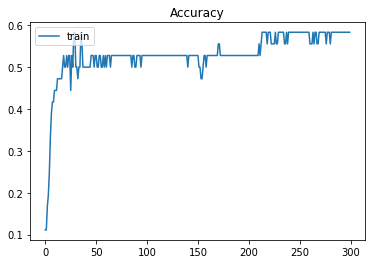

In [ ]:
import pickle
from sklearn.model_selection import train_test_split
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import os


# 分類するラベルの数
labelToCode = pickle.load(open(ml_dir + "text/label_to_code.pickle", "rb"))
nb_classes = len(labelToCode) 

# データベースの読込
data = pickle.load(open(ml_dir + "text/genre.pickle", "rb"))
y = data[0] # ラベルコード
x = data[1] # TF-IDF

# ラベルデータをone-hotベクトルに直す
y = tf.keras.utils.to_categorical(y, nb_classes)
in_size = x[0].shape[0] # 入力x[0]の要素数

# 学習用とテスト用を分ける
x_train, x_test, y_train, y_test = train_test_split(
        np.array(x), np.array(y), test_size=0.2)

# モデルを読み込む
model = tf.keras.models.load_model(ml_dir + 'text/hw_model.h5')

# 既に学習済みの重みデータが存在していれば読み込む
# if os.path.exists(ml_dir + 'text/hw_weights.h5'):
#     model.load_weights(ml_dir + 'text/hw_weights.h5')

# 学習を実行
hist = model.fit(x_train, y_train,
          batch_size=20, # 1回に計算するデータ数
          epochs=300,    # 学習の繰り返し回数みたいなもの
          verbose=1,
          validation_data=(x_test, y_test))

# 評価する
score = model.evaluate(x_test, y_test, verbose=1)
print("正解率=", score[1], 'loss=', score[0])

# 重みデータを保存
model.save_weights(ml_dir + 'text/hw_weights.h5')

# 学習の様子をグラフへ描画
plt.plot(hist.history['val_accuracy'])
plt.title('Accuracy')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

## 手順(7)  学習（MLP）モデルを実行して、判定

In [ ]:
import pickle
import tensorflow as tf


def inverse_dict(d):
    return {v:k for k,v in d.items()}

# モデルを読み込む
model = tf.keras.models.load_model(ml_dir + 'text/hw_model.h5')
# 学習済みの重みデータを読み込む
model.load_weights(ml_dir + 'text/hw_weights.h5')
# tfidオブジェクトをファイルよりロードする
vectorizer_loaded = pickle.load(open(ml_dir + "text/tfidf_vec.pickle", "rb"))
# ラベルの定義
labelToCode = pickle.load(open(ml_dir + "text/label_to_code.pickle", "rb"))
label_dic = inverse_dict(labelToCode)

# テキストを指定して判定
def getMusicName(text):
    # TF-IDFのベクトルに変換 
    data = vectorizer_loaded.transform([tokenize(text)]).toarray()
    # MLPで予測
    pre = model.predict(data)[0]
    sortIndexDesc = pre.argsort()[::-1];
    for no, ind in enumerate(sortIndexDesc, 1):
        print(f"{no}番目の答え: {label_dic[ind]}({pre[ind]:.4f})")
        if no == 5: break

    # n = pre.argmax()
    # print("一番目の答え : " + label_dic[n], "(", pre[n], ")")
    # # 2番以降
    # # desc_sort_list = pre.argsort()[::-1]
    # n_second = pre.argsort()[-2]
    # print("2番目の答え : " + label_dic[n_second], "(", pre[n_second], ")")

if __name__ == '__main__':
    # requestParam = """
    # 出会いに関しての歌で、中島みゆきさんが歌う
    # """
    requestParam = """
    知識をたくさん付けて選択肢を増やす
    """
    getMusicName(requestParam)

1番目の答え: 幸福(0.7904)
2番目の答え: 人間(0.2093)
3番目の答え: チャージ料金 1500円また,アルコール類を500円"より提供しております。[こちら](https://nango7.okbmk.com/nango/rt/system_nango_temp)"(0.0000)
4番目の答え: はい。演奏代無料で楽器演奏できます。(0.0000)
5番目の答え: お褒めの言葉、大変ありがとうございます。是非お越しください！！！！(0.0000)


In [ ]:
getMusicName(
    # """
    # 感情に惑わされず、好奇心をもって知識をたくさん付けて選択肢を増やすし、健康体を実現する
    # """
    """
    美味しい朝ご飯を食べる
    """
)

1番目の答え: 人間(0.9974)
2番目の答え: 幸福(0.0026)
3番目の答え: はい。演奏代無料で楽器演奏できます。(0.0000)
4番目の答え: ビール、各種日本酒、焼酎、酎ハイ、サワー等あります。ボトルキープも可です。詳細は[こちら](https://nango7.okbmk.com/nango/rt/drink_nango_temp)(0.0000)
5番目の答え: 状況により変わります。トップページをご覧ください。[こちら](https://nango7.okbmk.com/nango)(0.0000)


In [ ]:
import pickle
import tensorflow as tf
import pandas as pd


def inverse_dict(d):
    return {v:k for k,v in d.items()}

# モデルを読み込む
model = tf.keras.models.load_model(ml_dir + 'text/hw_model.h5')
# 学習済みの重みデータを読み込む
model.load_weights(ml_dir + 'text/hw_weights.h5')
# tfidオブジェクトをファイルよりロードする
vectorizer_loaded = pickle.load(open(ml_dir + "text/tfidf_vec.pickle", "rb"))
# ラベルの定義
labelToCode = pickle.load(open(ml_dir + "text/label_to_code.pickle", "rb"))
label_dic = inverse_dict(labelToCode)

# テキストを指定して判定
def predCatego(text):
    # TF-IDFのベクトルに変換 
    data = vectorizer_loaded.transform([tokenize(text)]).toarray()
    # MLPで予測
    pre = model.predict(data)[0]
    sortIndexDesc = pre.argsort()[::-1];
    catList = []
    catDic = {}
    for no, ind in enumerate(sortIndexDesc, 1):
        # catList.append({label_dic[ind]: pre[ind]})
        catDic[label_dic[ind]] = pre[ind]
        if no == 4: break

    return catDic

def showPred(text):
    data = vectorizer_loaded.transform([tokenize(text)]).toarray()
    pre = model.predict(data)[0]
    sortIndexDesc = pre.argsort()[::-1];
    for no, ind in enumerate(sortIndexDesc, 1):
        print(f"{no}番目の答え: {label_dic[ind]}({pre[ind]:.4f})")
        if no == 7: break

def isTrgText(text):
    trgCatList = ["人間", "幸福", "成る"]
    untiTrgCatList = ["不幸"]
    predDic = predCatego(text);

    return isInTrg(text, trgCatList, untiTrgCatList, predDic)

def isInTrg(text, trgCatList, untiTrgCatList, predDic):
    thVal = 0.2
    for trg in trgCatList:
        if trg not in predDic: return False
        if predDic[trg] < thVal: return False

    for uTrg in untiTrgCatList:
        if uTrg in predDic: return False
    
    return True

if __name__ == '__main__':
    requestParam = """
    知識をたくさん付けて選択肢を増やす
    """
    predCatego(requestParam)

In [ ]:
isTrgText(
    """
    感情に惑わされず、好奇心をもって知識をたくさん付けて選択肢を増やすし、健康体を実現する
    """
)

False

In [ ]:
import pandas as pd
import itertools

act_list = ['苦悩', '耐える', '発する', '知恵', '知ること', '好奇心', '食べる', '選択肢', '増える', 'テレビ', '美味しい'
 , '飛行機', '実現する', '良い', 'パートナー', '思い', '込み',  '道具', '作り', '瞑想', '存在', '採集', '狩猟', 'する', '朝ご飯', '幸せ'
 , '睡眠', '役立つ', '人', '言動']

cnt = 1
for wc in range(3, 6):
# for wc in range(3, len(act_list)):
    comb_list = list(itertools.combinations(act_list, wc))
    for comb in comb_list:
        text = ','.join(comb)
        print(f"\r計算回数: {cnt}", end='')
        # print(f"文章: {text}")
        if isTrgText(text):
            print(f"\n該当文章: {text}")
            showPred(text)
        cnt += 1

計算回数: 3834
該当文章: 道具,幸せ,言動
1番目の答え: 幸福(0.3965)
2番目の答え: 成る(0.3419)
3番目の答え: 人間(0.2512)
4番目の答え: サイト内に楽曲を紹介しているのでサイトマップから探してみてください。[こちら](https://nango7.okbmk.com/nango/rt/play_music_info_nango_temp)(0.0018)
5番目の答え: お料理は当日のおすすめメニューのみとなります。詳細は[こちら](https://nango7.okbmk.com/nango/rt/food_nango_temp)(0.0017)
6番目の答え: 予約可能です。10～30名様でご利用いただけるお得な貸切プランを各種ご用意しております。詳細は[こちら](https://nango7.okbmk.com/nango/rt/party_nango_temp)(0.0008)
7番目の答え: はい。演奏代無料で楽器演奏できます。(0.0008)
計算回数: 13689
該当文章: 発する,道具,幸せ,言動
1番目の答え: 幸福(0.3965)
2番目の答え: 成る(0.3419)
3番目の答え: 人間(0.2512)
4番目の答え: サイト内に楽曲を紹介しているのでサイトマップから探してみてください。[こちら](https://nango7.okbmk.com/nango/rt/play_music_info_nango_temp)(0.0018)
5番目の答え: お料理は当日のおすすめメニューのみとなります。詳細は[こちら](https://nango7.okbmk.com/nango/rt/food_nango_temp)(0.0017)
6番目の答え: 予約可能です。10～30名様でご利用いただけるお得な貸切プランを各種ご用意しております。詳細は[こちら](https://nango7.okbmk.com/nango/rt/party_nango_temp)(0.0008)
7番目の答え: はい。演奏代無料で楽器演奏できます。(0.0008)
計算回数: 28179
該当文章: 飛行機,道具,幸せ,言動
1番目の答え: 幸福(0.3965)
2番目の答え: 成る(0.3419)
3番目の答え: 人間(0.2

## 手順(8)  デプロイに必要な学習済みデータをダウンロード

In [ ]:
! zip -r res /content/gdrive/MyDrive/mnt_g_colab/text/
from google.colab import files
files.download('res.zip')

updating: text/ (stored 0%)
updating: text/genre.pickle (deflated 97%)
updating: text/genre-model.hdf5 (deflated 9%)
updating: text/genre-tdidf.dic (deflated 41%)
updating: text/label_to_code.pickle (deflated 64%)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# 以下は補足計算用

##学習データ取得用 PG

In [ ]:
!pip install bs4

In [ ]:
import requests as web
import bs4
import csv
import time

# 検索数
kensakuSu = 10

# これがないと説明文とれない
user_agent = "Mozilla/5.0 (Macintosh; Intel Mac OS X 10_12_6)" \
     "AppleWebKit/537.36 (KHTML, like Gecko)" \
     "Chrome/91.0.4472.114"

# with open('keys.csv', encoding='utf8') as keyListFile:
with open('g_output.csv','w',newline='',encoding='utf8') as outcsv:
    csvwriter = csv.writer(outcsv)
    csvwriter.writerow(['No','判定','項目名','説明'])
    # key_list = csv.reader(keyListFile)
    key_list = [["池袋 眼科 評判"],  ["池袋 眼科 飛蚊症"]]
    no = 0
    for key in key_list:
        resp = web.get('https://www.google.co.jp/search?num=100&q=' + '　'.join(key[0] + '')
                , headers={"User-Agent": user_agent})
        resp.raise_for_status()

        time.sleep(5) # スリープ

        # 取得したHTMLをパースする
        resp.encoding = 'utf8'  # 文字コード
        soup = bs4.BeautifulSoup(resp.text, "html.parser")

        # 検索結果の説明部分を取得
        contents = soup.select('div > .VwiC3b') # classの部分は毎回、dev toolsで確認する
        cnt = 0
        for ct in contents:
            cnt += 1
            no += 1
            content_text = ct.get_text().replace('\n','').replace('\r','').replace('\xa0...', '')
            print([no,'T', key[0], content_text])
            csvwriter.writerow([no,'T', key[0], content_text])
            if (cnt == kensakuSu): break

[1, 'T', '池袋 眼科 評判', '池袋サンシャイン通り眼科診療所の口コミ・評判はCalooでチェック！『親切です。』『駅から近くて便利』『ものもらいの治療で来院』『信頼できる』といった口コミ11件']
[2, 'T', '池袋 眼科 評判', '池袋駅周辺(1000m)の眼科を標榜する病院・クリニック 27件の一覧です。口コミ、評判、治療実績・手術件数から探せます。Calooでおすすめの病院を見つけませんか？']
[3, 'T', '池袋 眼科 評判', '池袋にある眼科、市橋眼科クリニックです。診療は眼科一般、19時15分まで受付。池袋駅前、東口徒歩1分、パルコ隣にあります。市橋眼科クリニックは土日・祝日も診療し']
[4, 'T', '池袋 眼科 評判', '2019年12月23日 — 池袋で評判のおすすめ眼科6医院！ · 中安眼科クリニック · 大沢眼科・内科 · 池袋サンシャイン通り眼科診療所 · 市橋眼科クリニック · 池袋クリスタル眼科.']
[5, 'T', '池袋 眼科 評判', '池袋さゆり眼科は令和元年11月10日開院。池袋駅東口から徒歩1分の住友池袋駅前ビル2Fにあり、土日・祝日も診療しています。眼科一般の他、日帰り白内障手術、']
[6, 'T', '池袋 眼科 評判', '東京都・池袋駅1分の眼科 中安眼科クリニックでは、結膜炎、白内障、緑内障、網膜疾患などの一般眼科を始め、コンタクトレンズの処方と装用指導、眼科疾患に関する']
[7, 'T', '池袋 眼科 評判', '池袋駅西口 地下鉄C1出口より徒歩1分、東京都豊島区池袋2-17-1 TEL:03-3971-2598 白内障、眼内レンズ移植、緑内障、網膜剥離、眼底出血、レーザー光凝固は大木眼科.']
[8, 'T', '池袋 眼科 評判', '2021年7月7日 — 池袋駅周辺の眼科には｢池袋サンシャイン通り眼科診療所｣｢大沢眼科・内科（医療法人 社団 碧 ... 池袋駅. 変更. 眼科（医院・クリニック・ヘルスケア）.']
[9, 'T', '池袋 眼科 評判', '池袋駅前、池袋東口から徒歩1分の眼科、池袋サンシャイン通り眼科診療所。平日土曜は午後7時半まで受付、日祝も午後6時半まで受付している池袋の眼科です。']
[10, 'T', '池袋 眼科 評判', '信頼と安

# bertテスト

## 日本語モデル？
このノートブックでは学習済みモデルの精度を実際に確認できるようにしてあります。 もし学習済みモデルをダウンロードしていない場合はhttps://drive.google.com/file/d/1-4dLB4T9h0XP-rpvYnbXvxBBnXW1vegi/view?usp=sharing からダウンロードして、google driveのマイドライブ直下に保存してください。

このノートブックは1.モデルを試す　からが本質になっているため、そこまではとりあえず実行してください。

In [ ]:
#このセルはとりあえず実行してください
!git clone https://github.com/huggingface/transformers
!git checkout efdb46b6e2a53f9126d447260f916cac33de58c3
!git clone https://github.com/NVIDIA/apex
!pip install -v --no-cache-dir apex/
!pip install mecab-python3==0.996.6rc2
!pip install transformers==2.8.0
!git clone https://github.com/kuma807/bert_qa.git

fatal: destination path 'transformers' already exists and is not an empty directory.
fatal: not a git repository (or any of the parent directories): .git
fatal: destination path 'apex' already exists and is not an empty directory.
Created temporary directory: /tmp/pip-ephem-wheel-cache-264758mk
Created temporary directory: /tmp/pip-req-tracker-sy_4cmgk
Created requirements tracker '/tmp/pip-req-tracker-sy_4cmgk'
Created temporary directory: /tmp/pip-install-740370gm
Processing ./apex
  Created temporary directory: /tmp/pip-req-build-giu1taa3
  Added file:///content/apex to build tracker '/tmp/pip-req-tracker-sy_4cmgk'
    Running setup.py (path:/tmp/pip-req-build-giu1taa3/setup.py) egg_info for package from file:///content/apex
    Running command python setup.py egg_info
    No CUDA runtime is found, using CUDA_HOME='/usr/local/cuda'

     If your intention is to cross-compile, this is not an error.
    By default, Apex will cross-compile for Pascal (compute capabilities 6.0, 6.1, 6.2

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:


model_dir = "gdrive/MyDrive/temp_bert/pytorch_model.bin"

In [ ]:
#モデルと予想用関数の設定
from transformers import BertTokenizer, BertForQuestionAnswering, AutoTokenizer, AutoConfig
import torch
config = AutoConfig.from_pretrained("bert_qa/config.json")
tokenizer_config = AutoConfig.from_pretrained("bert_qa/tokenizer_config.json")
model = BertForQuestionAnswering.from_pretrained("cl-tohoku/bert-base-japanese-whole-word-masking", config=config)
model.load_state_dict(torch.load(model_dir, map_location=torch.device('cpu')))
tokenizer = AutoTokenizer.from_pretrained("cl-tohoku/bert-base-japanese-whole-word-masking", config=tokenizer_config)
def predict(quesion, text):
  input_ids = tokenizer.encode(quesion, text)
  token_type_ids = [0 if i <= input_ids.index(3) else 1 for i in range(len(input_ids))]
  start_scores, end_scores = model(torch.tensor([input_ids]), token_type_ids=torch.tensor([token_type_ids]))
  score = torch.max(start_scores).item() + torch.max(end_scores).item()
  all_tokens = tokenizer.convert_ids_to_tokens(input_ids)
  prediction = ''.join(all_tokens[torch.argmax(start_scores) : torch.argmax(end_scores)+1])
  prediction = prediction.replace("##", "")
  return prediction, score

In [ ]:
#例1
text = """
リンゴの果実は直径約3 - 15 センチメートル (cm) 、重さ約35 - 1000グラム (g) 。
外皮の色は赤や黄緑または黄色をしている。熟するとヘプタコサンを含んだ蝋状の分泌物に覆われる。
果肉は淡黄色から白色の品種が多い。外皮近くなど果肉が赤からピンク色になる赤肉系の品種もある。
以前、こうした赤肉系の品種は渋みが強く生食に向かなかったが、2010年代になると日本では生食でも美味な赤肉系が品種改良により相次ぎ生み出された。
弘前大学（青森県）の「紅の夢」「HFF60」「HFF33」、農研機構の「ローズパール」、信州大学の「レッドセンセーション」[14]、青森県五所川原市の「栄紅」（えいこう）や「レッド キュー」[15] などである。
"""
quesion = "日本ではいつからおいしいりんごが作られている？"

prediction, score = predict(quesion, text)
print("モデルの予想結果:", prediction)
print(score)

モデルの予想結果: 2010年代
13.61179780960083


In [ ]:
#例2
text = """
紀元前10世紀ごろに成立したと見られるヤハウェ信仰者による出典によると、ヤハウェは地が乾きなにも生えていないころに最初にアダムを創造したとされる。
ヤハウェは地面の土（アダマ）を使ってアダムの形を作り、鼻の穴からルーアハを吹き込んだ。
"""

quesion = "りんごは何色ですか？"
prediction, score = predict(quesion, text)
print("モデルの予想結果:", prediction)

モデルの予想結果: [CLS]


In [ ]:
import MeCab
mecab = MeCab.Tagger("-Ochasen")

In [ ]:
print(mecab.parse("atcoderの社長は誰ですか？"))

atcoder	atcoder	atcoder	名詞-固有名詞-組織		
の	ノ	の	助詞-連体化		
社長	シャチョウ	社長	名詞-一般		
は	ハ	は	助詞-係助詞		
誰	ダレ	誰	名詞-代名詞-一般		
です	デス	です	助動詞	特殊・デス	基本形
か	カ	か	助詞-副助詞／並立助詞／終助詞		
？	？	？	記号-一般		
EOS



In [ ]:
#例1
context = """
チャージ料金 1500円また、アルコール類を500円より提供しております。
"""
quesion = "チャージ料金はいくらですか？"

prediction, score = predict(quesion, context)
print('答え: ' + prediction)
print(score)

答え: 1500円
13.75549030303955


In [ ]:
context = """
チャージ料金 1500円また、アルコール類を500円より提供しております。
"""
quesion = "アルコール類はいくらですか？"

prediction, score = predict(quesion, context)
print('答え: ' + prediction)
print(score)

答え: 500円
7.591254949569702
